# Preparing and Analysing Expert Evaluation

## Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import networkx as nx
from networkx.algorithms import bipartite
from argparse import Namespace
import random as random
import seaborn as sns # gives a better presentation for matplotlib
sns.set()

## Load in the Data

In [164]:
models = ['ulmfit', 'bert']
files = ['error_analysis', 'venice_des_pred', 'social_media_pred']
categories = ['justification', 'description', 'social_media']
classes = ['Criteria i', 'Criteria ii', 'Criteria iii', 'Criteria iv', 'Criteria v', 'Criteria vi', 
              'Criteria vii', 'Criteria viii', 'Criteria ix', 'Criteria x', 'Others']
cul = set(classes[:6])

In [17]:
data = {}
for m in models:
    for i in range(len(files)):
        file = files[i] + '.csv'
        cat = categories[i]
        if i==2:
            temp = pd.read_csv('Results/'+m +'/'+file,decimal='\t')
        else:
            temp = pd.read_csv('Results/'+m + '/'+file)
        temp_dict = pd.DataFrame.to_dict(temp)
        if cat in data:
            data[cat][m] = temp_dict
        else:
            data[cat] = {}
            data[cat][m] = temp_dict

In [33]:
sm_df = pd.DataFrame.from_dict(data['social_media']['ulmfit'])[['data','origin','ids']]

## Preparing Human Evaluation Dataset

### Checking the Consistency of BERT and ULMFiT predictions for Social Media Data

In [142]:
for m in models:
    for i in range(1,4):
        sm_df[m+'_max_'+str(i)+'_val'] = pd.Series(data['social_media'][m]['max_'+str(i)+'_val']).astype(float)
        sm_df[m+'_max_'+str(i)+'_col'] = pd.Series(data['social_media'][m]['max_'+str(i)+'_col'])
    sm_df[m+'_max_1'] = pd.Series(data['social_media'][m]['max_1']).astype(float)
    sm_df[m+'_max_3'] = pd.Series(data['social_media'][m]['max_3']).astype(float)

In [65]:
sm_df['same_1'] = (sm_df['bert_max_1_col']==sm_df['ulmfit_max_1_col'])
sm_df['same_1'].value_counts()

False    609
True     523
Name: same_1, dtype: int64

In [42]:
def IoU(line):
    a = set()
    b = set()
    for i in range(1,4):
        a.add(line['bert_max_'+str(i)+'_col'])
        b.add(line['ulmfit_max_'+str(i)+'_col'])
    I = a.intersection(b)
    O = a.union(b)
    return len(I)/len(O)

In [46]:
iou = []
for i in range(len(sm_df)):
    iou.append(IoU(sm_df.iloc[i]))

In [64]:
sm_df['same_3'] = iou
sm_df['same_3'].value_counts()

0.5    564
1.0    301
0.2    222
0.0     45
Name: same_3, dtype: int64

### Checking the Consistency of BERT and ULMFiT predictions for SOUV Data in Venice

In [138]:
vn_df = pd.DataFrame.from_dict(data['description']['ulmfit'])[['data','id','source']]
for m in models:
    for i in range(1,4):
        vn_df[m+'_max_'+str(i)+'_val'] = pd.Series(data['description'][m]['max_'+str(i)+'_val']).astype(float)
        vn_df[m+'_max_'+str(i)+'_col'] = pd.Series(data['description'][m]['max_'+str(i)+'_col'])
    vn_df[m+'_max_1'] = pd.Series(data['description'][m]['max_1']).astype(float)
    vn_df[m+'_max_3'] = pd.Series(data['description'][m]['max_3']).astype(float)
vn_df['same_1'] = (vn_df['bert_max_1_col']==vn_df['ulmfit_max_1_col'])
vn_df['same_1'].value_counts()

True     22
False    10
Name: same_1, dtype: int64

In [139]:
iou = []
for i in range(len(vn_df)):
    iou.append(IoU(vn_df.iloc[i]))
vn_df['same_3'] = iou
vn_df['same_3'].value_counts()

0.5    15
1.0    14
0.2     3
Name: same_3, dtype: int64

### Creating a New Social Media Dataset that is consistent

In [143]:
new_sm = sm_df[sm_df['same_3']>=0.5][sm_df['ulmfit_max_3']>0.8][sm_df['bert_max_3']>0.8]
(len(new_sm['ids'].unique()), len(sm_df['ids'].unique())/4196, len(new_sm['ids'].unique())/4196)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(158, 0.07888465204957101, 0.03765490943755958)

In [105]:
new_sm

,data,origin,ids,ulmfit_max_1_val,ulmfit_max_1_col,ulmfit_max_2_val,ulmfit_max_2_col,ulmfit_max_3_val,ulmfit_max_3_col,ulmfit_max_1,...,bert_max_1_val,bert_max_1_col,bert_max_2_val,bert_max_2_col,bert_max_3_val,bert_max_3_col,bert_max_1,bert_max_3,same_1,same_3
0,The banks of the Grand Canal are lined with mo...,18,50765664756,0.5483404994010925,Criteria iv,0.24928317964076996,Criteria iii,0.07154890149831772,Criteria i,0.548340,...,0.7677510380744934,Criteria iv,0.12191740423440933,Criteria i,0.05188407003879547,Criteria iii,0.767751,0.941553,True,1.0
13,The building was constructed for the doge Fran...,55,50728484938,0.8104153871536255,Criteria i,0.08404466509819031,Criteria ii,0.06439588963985443,Criteria iv,0.810415,...,0.809202253818512,Criteria i,0.05672677233815193,Criteria iv,0.048785120248794556,Criteria vi,0.809202,0.914714,True,0.5
29,It is a particularly notable example of the 18...,150,50627599883,0.45021599531173706,Criteria i,0.3768940269947052,Criteria iv,0.1061236560344696,Criteria ii,0.450216,...,0.4778384566307068,Criteria i,0.34760504961013794,Criteria iv,0.07607655972242355,Criteria ii,0.477838,0.901520,True,1.0
31,restoration of Titian's Assumption of Virgin a...,190,50600724958,0.583702802658081,Criteria i,0.18121281266212463,Criteria iv,0.10557761043310165,Criteria ii,0.583703,...,0.8367812037467957,Criteria i,0.05121351778507233,Criteria ii,0.02883687987923622,Criteria vi,0.836781,0.916832,True,0.5
34,"overall design created by Canova in 1794, orig...",226,50587740197,0.5144568085670471,Criteria i,0.2216433733701706,Criteria ii,0.12096361815929413,Criteria iv,0.514457,...,0.6706072092056274,Criteria i,0.21963731944561005,Criteria ii,0.03135381639003754,Criteria iv,0.670607,0.921598,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,"Mark's Basilica, at the time a small chapel wh...",4189,50758454032,0.4130445122718811,Criteria i,0.2713911235332489,Criteria iv,0.16776078939437866,Criteria ii,0.413045,...,0.5005559325218201,Criteria iv,0.1859009861946106,Criteria ii,0.1302618384361267,Criteria vi,0.500556,0.816719,False,0.5
1123,The square became paved with bricks in 1267 in...,4189,50758454032,0.495177686214447,Criteria i,0.2629472017288208,Criteria iv,0.09369052946567535,Criteria iii,0.495178,...,0.48866066336631775,Criteria iv,0.29683277010917664,Criteria i,0.07183440774679184,Criteria iii,0.488661,0.857328,False,1.0
1124,In 1735 the bricks were replaced with natural ...,4189,50758454032,0.4523472487926483,Criteria i,0.24525927007198334,Criteria iv,0.13748183846473694,Criteria iii,0.452347,...,0.588363766670227,Criteria i,0.18538692593574524,Criteria ii,0.13227345049381256,Criteria iv,0.588364,0.906024,True,0.5
1126,The name San Marco comes from the remains of t...,4189,50758454032,0.42960938811302185,Criteria vi,0.28626254200935364,Criteria iii,0.1319708377122879,Criteria iv,0.429609,...,0.5782033205032349,Criteria vi,0.1474798619747162,Criteria iii,0.09516898542642593,Criteria i,0.578203,0.820852,True,0.5


### Plotting the Distributions of different Data Sources

<AxesSubplot:>

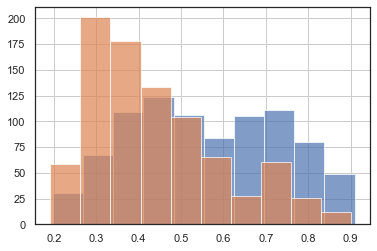

In [101]:
import seaborn as sns
sns.set(style="white")
plt.figure()
sm_df[sm_df['same_3']>=0.5]['bert_max_1'].hist(alpha=.7, bins=10)
sm_df[sm_df['same_3']>=0.5]['ulmfit_max_1'].hist(alpha=.7, bins=10)

<AxesSubplot:>

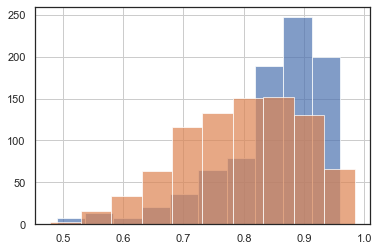

In [102]:
import seaborn as sns
sns.set(style="white")
plt.figure()
sm_df[sm_df['same_3']>=0.5]['bert_max_3'].hist(alpha=.7, bins=10)
sm_df[sm_df['same_3']>=0.5]['ulmfit_max_3'].hist(alpha=.7, bins=10)

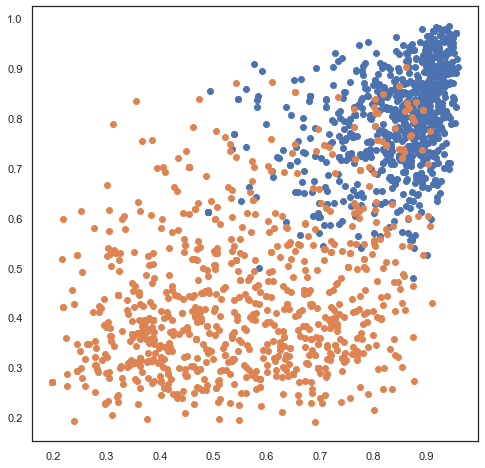

In [103]:
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(8,8))
plt.scatter(sm_df[sm_df['same_3']>=0.5]['bert_max_3'],sm_df[sm_df['same_3']>=0.5]['ulmfit_max_3'])
plt.scatter(sm_df[sm_df['same_3']>=0.5]['bert_max_1'],sm_df[sm_df['same_3']>=0.5]['ulmfit_max_1'])

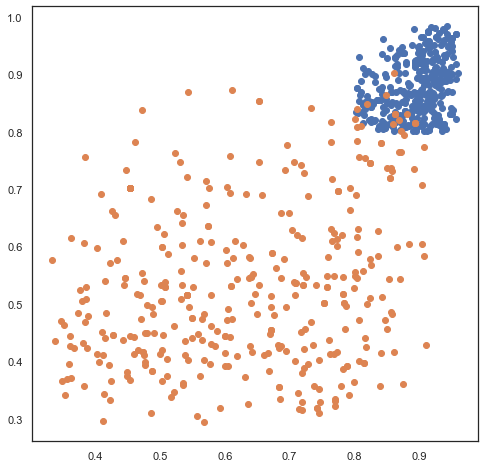

In [104]:
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(8,8))
plt.scatter(new_sm['bert_max_3'],new_sm['ulmfit_max_3'])
plt.scatter(new_sm['bert_max_1'],new_sm['ulmfit_max_1'])

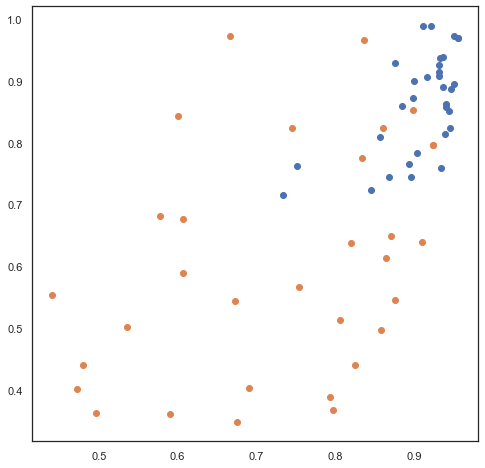

In [124]:
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(8,8))
plt.scatter(vn_df['bert_max_3'],vn_df['ulmfit_max_3'])
plt.scatter(vn_df['bert_max_1'],vn_df['ulmfit_max_1'])

### Creating a new Dataset about SOUV in Venice

In [126]:
vn_df[vn_df.same_3>=0.5]['source'].value_counts()

ouv_criteria         15
brief_synthesis      12
short_description     2
Name: source, dtype: int64

In [198]:
vn_df['source'].value_counts()

brief_synthesis      15
ouv_criteria         15
short_description     2
Name: source, dtype: int64

In [140]:
new_vn = vn_df[vn_df.same_3>=0.5]
new_vn['sm'] = False
new_vn

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,data,id,source,ulmfit_max_1_val,ulmfit_max_1_col,ulmfit_max_2_val,ulmfit_max_2_col,ulmfit_max_3_val,ulmfit_max_3_col,ulmfit_max_1,...,bert_max_1_col,bert_max_2_val,bert_max_2_col,bert_max_3_val,bert_max_3_col,bert_max_1,bert_max_3,same_1,same_3,sm
0,with the unusualness of an archaeological site...,394,ouv_criteria,0.825067,Criteria iii,0.054071,Criteria iv,0.050640,Criteria vi,0.825067,...,Criteria iii,0.068596,Criteria vi,0.062014,Criteria iv,0.744821,0.875431,True,1.0,False
1,venice symbolizes the peoples victorious strug...,394,ouv_criteria,0.513123,Criteria vi,0.350249,Criteria iii,0.043167,Criteria iv,0.513123,...,Criteria vi,0.056295,Criteria iv,0.053275,Criteria iii,0.806835,0.916405,True,1.0,False
2,it was from venice that marco polo <NUM> <NUM...,394,ouv_criteria,0.496437,Criteria ii,0.284507,Criteria vi,0.133785,Criteria iii,0.496437,...,Criteria vi,0.039716,Criteria iii,0.033637,Criteria ii,0.858362,0.931715,False,1.0,False
3,"the queen of the seas , heroically perched on ...",394,ouv_criteria,0.388274,Criteria vi,0.181272,Criteria iii,0.175940,Criteria ii,0.388274,...,Criteria vi,0.056981,Criteria iii,0.045780,Criteria iv,0.793053,0.895814,True,0.5,False
4,this mistress of the seas is a link between th...,394,ouv_criteria,0.546323,Criteria iii,0.237195,Criteria vi,0.074871,Criteria iv,0.546323,...,Criteria iii,0.036002,Criteria vi,0.029387,Criteria iv,0.875700,0.941090,True,1.0,False
5,the city is also directly and tangibly associa...,394,ouv_criteria,0.967563,Criteria vi,0.012927,Criteria iii,0.008728,Criteria iv,0.967563,...,Criteria vi,0.051319,Criteria iv,0.033774,Criteria ii,0.836889,0.921983,True,0.5,False
6,"in the mediterranean area , the lagoon of veni...",394,ouv_criteria,0.973514,Criteria v,0.011216,Criteria iv,0.004546,Criteria ii,0.973514,...,Criteria v,0.210469,Criteria iv,0.034011,Criteria ii,0.667083,0.911563,True,1.0,False
7,venice possesses an incomparable series of arc...,394,ouv_criteria,0.638974,Criteria iv,0.131317,Criteria iii,0.125198,Criteria i,0.638974,...,Criteria iv,0.023314,Criteria i,0.017931,Criteria iii,0.909866,0.951112,True,1.0,False
8,but when it began to lose its power over the s...,394,ouv_criteria,0.824323,Criteria ii,0.070717,Criteria iv,0.045005,Criteria iii,0.824323,...,Criteria ii,0.038627,Criteria iv,0.037064,Criteria iii,0.861004,0.936695,True,1.0,False
9,the influence of venice on the development of ...,394,ouv_criteria,0.853826,Criteria ii,0.081081,Criteria iv,0.037684,Criteria iii,0.853826,...,Criteria ii,0.035560,Criteria iv,0.016321,Criteria i,0.898442,0.950323,True,0.5,False


### Constructing the Dataset for Expert Evaluation

In [144]:
rating = new_sm.sample(n=30, random_state=42)
rating['sm'] = True
rating

,data,origin,ids,ulmfit_max_1_val,ulmfit_max_1_col,ulmfit_max_2_val,ulmfit_max_2_col,ulmfit_max_3_val,ulmfit_max_3_col,ulmfit_max_1,...,bert_max_1_col,bert_max_2_val,bert_max_2_col,bert_max_3_val,bert_max_3_col,bert_max_1,bert_max_3,same_1,same_3,sm
769,"If the buildings would be straight, painted ; ...",2877,50013352498,0.702326,Criteria i,0.112619,Criteria ii,0.082982,Criteria iv,0.702326,...,Criteria i,0.420170,Criteria iv,0.045696,Criteria ii,0.453567,0.919432,True,1.0,True
128,The lower ones are inlaid worked with figures ...,933,50045983587,0.319195,Criteria iv,0.318245,Criteria iii,0.200312,Criteria i,0.319195,...,Criteria i,0.136729,Criteria iii,0.118159,Criteria ii,0.592862,0.847750,False,0.5,True
436,"People spoke together, they looked at oneself,...",1596,50561145161,0.482413,Criteria iii,0.288102,Criteria vi,0.143657,Criteria ii,0.482413,...,Criteria vi,0.130281,Criteria iii,0.081061,Criteria iv,0.650442,0.861784,False,0.5,True
122,"The large choir, located in the central nave o...",933,50045983587,0.398807,Criteria i,0.311838,Criteria iv,0.155215,Criteria ii,0.398807,...,Criteria iv,0.317055,Criteria i,0.152793,Criteria iii,0.407012,0.876860,False,0.5,True
1015,It was originally the home to one of the Scuol...,3413,50070034327,0.454520,Criteria vi,0.251789,Criteria iii,0.129188,Criteria iv,0.454520,...,Criteria iv,0.117286,Criteria vi,0.090139,Criteria i,0.670608,0.878033,False,0.5,True
485,"Saint Christopher, Saint Vincent Ferreri, Sain...",1956,50415253783,0.654851,Criteria vi,0.137528,Criteria i,0.078531,Criteria iv,0.654851,...,Criteria vi,0.279985,Criteria i,0.058888,Criteria iv,0.535623,0.874496,True,1.0,True
393,structural model of the basilica showing a cro...,1419,50668336558,0.621136,Criteria i,0.243790,Criteria iv,0.114228,Criteria ii,0.621136,...,Criteria i,0.331605,Criteria iv,0.052869,Criteria ii,0.506259,0.890733,True,1.0,True
110,"Sculpted by Pietro da Salò in 1541, the statue...",926,50073923062,0.872118,Criteria i,0.039177,Criteria iv,0.030881,Criteria iii,0.872118,...,Criteria i,0.156807,Criteria iii,0.100185,Criteria vi,0.611096,0.868088,True,0.5,True
311,"If the buildings would be straight, painted ; ...",1152,50030475391,0.702326,Criteria i,0.112619,Criteria ii,0.082982,Criteria iv,0.702326,...,Criteria i,0.420170,Criteria iv,0.045696,Criteria ii,0.453567,0.919432,True,1.0,True
375,"Mark's basilic until 1977, after restoration t...",1333,50679925876,0.426976,Criteria i,0.270839,Criteria iv,0.177727,Criteria ii,0.426976,...,Criteria i,0.110588,Criteria ii,0.107090,Criteria iii,0.585713,0.803391,True,0.5,True


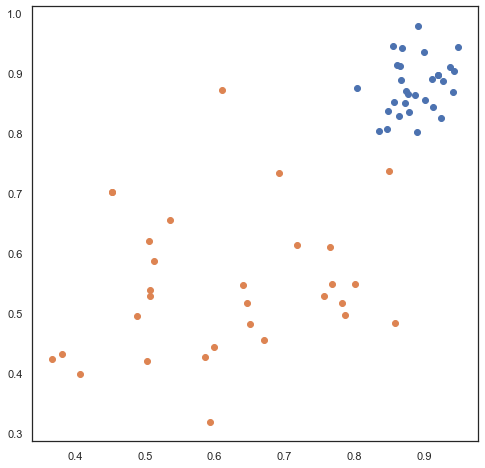

In [128]:
sns.set(style="white")
plt.figure(figsize=(8,8))
plt.scatter(rating['bert_max_3'],rating['ulmfit_max_3'])
plt.scatter(rating['bert_max_1'],rating['ulmfit_max_1'])

In [145]:
rates = pd.concat([new_vn,rating])
rates

,data,id,source,ulmfit_max_1_val,ulmfit_max_1_col,ulmfit_max_2_val,ulmfit_max_2_col,ulmfit_max_3_val,ulmfit_max_3_col,ulmfit_max_1,...,bert_max_2_col,bert_max_3_val,bert_max_3_col,bert_max_1,bert_max_3,same_1,same_3,sm,origin,ids
0,with the unusualness of an archaeological site...,394.0,ouv_criteria,0.825067,Criteria iii,0.054071,Criteria iv,0.050640,Criteria vi,0.825067,...,Criteria vi,0.062014,Criteria iv,0.744821,0.875431,True,1.0,False,NaN,NaN
1,venice symbolizes the peoples victorious strug...,394.0,ouv_criteria,0.513123,Criteria vi,0.350249,Criteria iii,0.043167,Criteria iv,0.513123,...,Criteria iv,0.053275,Criteria iii,0.806835,0.916405,True,1.0,False,NaN,NaN
2,it was from venice that marco polo <NUM> <NUM...,394.0,ouv_criteria,0.496437,Criteria ii,0.284507,Criteria vi,0.133785,Criteria iii,0.496437,...,Criteria iii,0.033637,Criteria ii,0.858362,0.931715,False,1.0,False,NaN,NaN
3,"the queen of the seas , heroically perched on ...",394.0,ouv_criteria,0.388274,Criteria vi,0.181272,Criteria iii,0.175940,Criteria ii,0.388274,...,Criteria iii,0.045780,Criteria iv,0.793053,0.895814,True,0.5,False,NaN,NaN
4,this mistress of the seas is a link between th...,394.0,ouv_criteria,0.546323,Criteria iii,0.237195,Criteria vi,0.074871,Criteria iv,0.546323,...,Criteria vi,0.029387,Criteria iv,0.875700,0.941090,True,1.0,False,NaN,NaN
5,the city is also directly and tangibly associa...,394.0,ouv_criteria,0.967563,Criteria vi,0.012927,Criteria iii,0.008728,Criteria iv,0.967563,...,Criteria iv,0.033774,Criteria ii,0.836889,0.921983,True,0.5,False,NaN,NaN
6,"in the mediterranean area , the lagoon of veni...",394.0,ouv_criteria,0.973514,Criteria v,0.011216,Criteria iv,0.004546,Criteria ii,0.973514,...,Criteria iv,0.034011,Criteria ii,0.667083,0.911563,True,1.0,False,NaN,NaN
7,venice possesses an incomparable series of arc...,394.0,ouv_criteria,0.638974,Criteria iv,0.131317,Criteria iii,0.125198,Criteria i,0.638974,...,Criteria i,0.017931,Criteria iii,0.909866,0.951112,True,1.0,False,NaN,NaN
8,but when it began to lose its power over the s...,394.0,ouv_criteria,0.824323,Criteria ii,0.070717,Criteria iv,0.045005,Criteria iii,0.824323,...,Criteria iv,0.037064,Criteria iii,0.861004,0.936695,True,1.0,False,NaN,NaN
9,the influence of venice on the development of ...,394.0,ouv_criteria,0.853826,Criteria ii,0.081081,Criteria iv,0.037684,Criteria iii,0.853826,...,Criteria iv,0.016321,Criteria i,0.898442,0.950323,True,0.5,False,NaN,NaN


### Generating the Positive and Negative Classes for Evaluation

In [174]:
def gen_pos(line):
    c = dict()
    for i in range(1,4):
        a = (line['bert_max_'+str(i)+'_col'], line['bert_max_'+str(i)+'_val'])
        b = (line['ulmfit_max_'+str(i)+'_col'], line['ulmfit_max_'+str(i)+'_val'])
        if a[0]==b[0]:
            if len(c)<3:
                c[a[0]] = max(a[1],b[1])
        elif a[1] >= b[1]:
            if a[0] not in c and len(c)<3:
                c[a[0]] = a[1]
            if b[0] not in c and len(c)<3:
                c[b[0]] = b[1]
        else:
            if b[0] not in c and len(c)<3:
                c[b[0]] = b[1]
            if a[0] not in c and len(c)<3:
                c[a[0]] = a[1]
                          
    #return [(key,val) for key,val in c.items()]
    return list(c)

In [172]:
def gen_neg(line):
    d = set()
    for i in range(1,4):
        a = (line['bert_max_'+str(i)+'_col'], line['bert_max_'+str(i)+'_val'])
        b = (line['ulmfit_max_'+str(i)+'_col'], line['ulmfit_max_'+str(i)+'_val'])
        
        d.add(a[0])
        d.add(b[0])
    
    return random.sample(cul.difference(d),1)

In [175]:
gen_pos(rates.iloc[1])

['Criteria vi', 'Criteria iii', 'Criteria iv']

In [173]:
gen_neg(rates.iloc[1])

['Criteria v']

In [195]:
pos = []
neg = []
for i in range(len(rates)):
    pos.append(gen_pos(rates.iloc[i]))
    neg.append(gen_neg(rates.iloc[i]))

In [180]:
rates['pos'] = pos
rates['neg'] = neg

### Saving the Dataset for Human Evaluation

In [197]:
rates.to_csv('human_rates.csv',sep='\t')

## Analysing Human Evaluation Dataset

### Pre-processing Questionnaire Data

In [779]:
experts = pd.read_csv('Data/Questionnaire/OUV_Venice_expert_May+9%2C+2021_05.19.csv',header=1).drop(0).T.reset_index()

In [780]:
experts

,index,1,2,3,4,5,6,7,8
0,Start Date,2021-05-03 06:39:02,2021-05-03 14:17:09,2021-05-03 04:31:41,2021-05-07 01:30:09,2021-05-07 03:09:14,2021-05-07 04:55:36,2021-05-03 11:11:22,2021-05-03 08:11:09
1,End Date,2021-05-03 07:26:07,2021-05-03 15:26:49,2021-05-04 01:31:47,2021-05-07 02:01:59,2021-05-07 03:49:12,2021-05-07 06:23:36,2021-05-07 09:45:20,2021-05-08 07:25:54
2,Response Type,0,0,0,0,0,0,0,0
3,IP Address,31.21.106.10,85.144.59.160,94.62.217.16,80.113.22.187,183.172.233.92,124.202.177.22,83.86.174.112,138.201.161.174
4,Progress,100,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...
259,"In general, please indicate how the following ...",4,5,4,5,2,4,5,4
260,"In general, please indicate how the following ...",4,2,2,5,1,3,1,3
261,Please give us some thoughts and opinions of t...,NaN,NaN,"To be aware of the lengh of the survey, the pr...",NaN,NaN,NaN,The questionnaire is too long; giving a N.A. o...,NaN
262,Open Question - Parent Topics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [781]:
experts.iloc[16:26]

,index,1,2,3,4,5,6,7,8
16,User Language,EN,EN,EN,EN,EN,EN,EN,EN
17,Please indicate how the following statements s...,4,5,5,4,5,3,4,5
18,Please indicate how the following statements s...,2,5,4,4,5,4,4,3
19,Please indicate how the following statements s...,3,5,4,3,5,1,2,1
20,Please indicate how the following statements s...,5,5,5,4,5,5,4,5
21,Please indicate how the following statements s...,3,5,2,4,4,1,4,1
22,"This is a masterpiece in architecture history,...",5,5,5,2,5,5,4,4
23,"This is a masterpiece in architecture history,...",5,5,5,5,5,5,5,5
24,"This is a masterpiece in architecture history,...",4,5,5,3,5,2,5,5
25,"This is a masterpiece in architecture history,...",1,3,1,5,2,5,3,1


### The Rating Dataset

In [782]:
experts_rates = experts.iloc[26:254].drop([134, 135, 136, 137])
experts_rates

,index,1,2,3,4,5,6,7,8
26,With the unusualness of an archaeological site...,5,5,5,3,5,5,4,5
27,With the unusualness of an archaeological site...,2,5,1,5,1,2,1,1
28,With the unusualness of an archaeological site...,2,5,1,1,5,2,1,1
29,With the unusualness of an archaeological site...,4,1,1,1,2,2,2,1
30,Venice symbolizes the peoples' victorious stru...,4,5,5,5,4,2,4,3
...,...,...,...,...,...,...,...,...,...
249,The enclosed bridge is made of white limestone...,4,4,1,2,1,4,4,1
250,"Peter, wearing a delightful blue vestment with...",3,2,3,1,1,1,1,1
251,"Peter, wearing a delightful blue vestment with...",3,4,1,1,1,1,1,1
252,"Peter, wearing a delightful blue vestment with...",4,4,2,3,4,5,3,2


### Re-structure the model ratings for fitting the Orders

In [735]:
rates_new = rates.drop([30,31,311])

In [ ]:
rates_new['neg'].loc._setitem_with_indexer(16,['Criteria i'])

In [737]:
rates_new=rates_new.append(rates_new.loc[220],ignore_index=True).drop(44)

In [931]:
rates_new

,data,id,source,ulmfit_max_1_val,ulmfit_max_1_col,ulmfit_max_2_val,ulmfit_max_2_col,ulmfit_max_3_val,ulmfit_max_3_col,ulmfit_max_1,...,bert_max_3_col,bert_max_1,bert_max_3,same_1,same_3,sm,origin,ids,pos,neg
0,with the unusualness of an archaeological site...,394.0,ouv_criteria,0.825067,Criteria iii,0.054071,Criteria iv,0.050640,Criteria vi,0.825067,...,Criteria iv,0.744821,0.875431,True,1.0,False,NaN,NaN,"[Criteria iii, Criteria vi, Criteria iv]",[Criteria v]
1,venice symbolizes the peoples victorious strug...,394.0,ouv_criteria,0.513123,Criteria vi,0.350249,Criteria iii,0.043167,Criteria iv,0.513123,...,Criteria iii,0.806835,0.916405,True,1.0,False,NaN,NaN,"[Criteria vi, Criteria iii, Criteria iv]",[Criteria i]
2,it was from venice that marco polo <NUM> <NUM...,394.0,ouv_criteria,0.496437,Criteria ii,0.284507,Criteria vi,0.133785,Criteria iii,0.496437,...,Criteria ii,0.858362,0.931715,False,1.0,False,NaN,NaN,"[Criteria vi, Criteria ii, Criteria iii]",[Criteria iv]
3,"the queen of the seas , heroically perched on ...",394.0,ouv_criteria,0.388274,Criteria vi,0.181272,Criteria iii,0.175940,Criteria ii,0.388274,...,Criteria iv,0.793053,0.895814,True,0.5,False,NaN,NaN,"[Criteria vi, Criteria iii, Criteria ii]",[Criteria i]
4,this mistress of the seas is a link between th...,394.0,ouv_criteria,0.546323,Criteria iii,0.237195,Criteria vi,0.074871,Criteria iv,0.546323,...,Criteria iv,0.875700,0.941090,True,1.0,False,NaN,NaN,"[Criteria iii, Criteria vi, Criteria iv]",[Criteria ii]
5,the city is also directly and tangibly associa...,394.0,ouv_criteria,0.967563,Criteria vi,0.012927,Criteria iii,0.008728,Criteria iv,0.967563,...,Criteria ii,0.836889,0.921983,True,0.5,False,NaN,NaN,"[Criteria vi, Criteria iv, Criteria iii]",[Criteria v]
6,"in the mediterranean area , the lagoon of veni...",394.0,ouv_criteria,0.973514,Criteria v,0.011216,Criteria iv,0.004546,Criteria ii,0.973514,...,Criteria ii,0.667083,0.911563,True,1.0,False,NaN,NaN,"[Criteria v, Criteria iv, Criteria ii]",[Criteria vi]
7,venice possesses an incomparable series of arc...,394.0,ouv_criteria,0.638974,Criteria iv,0.131317,Criteria iii,0.125198,Criteria i,0.638974,...,Criteria iii,0.909866,0.951112,True,1.0,False,NaN,NaN,"[Criteria iv, Criteria iii, Criteria i]",[Criteria ii]
8,but when it began to lose its power over the s...,394.0,ouv_criteria,0.824323,Criteria ii,0.070717,Criteria iv,0.045005,Criteria iii,0.824323,...,Criteria iii,0.861004,0.936695,True,1.0,False,NaN,NaN,"[Criteria ii, Criteria iv, Criteria iii]",[Criteria v]
9,the influence of venice on the development of ...,394.0,ouv_criteria,0.853826,Criteria ii,0.081081,Criteria iv,0.037684,Criteria iii,0.853826,...,Criteria i,0.898442,0.950323,True,0.5,False,NaN,NaN,"[Criteria ii, Criteria iv, Criteria iii]",[Criteria v]


### Extracting Confidence Scores from Both Models

In [739]:
bert_scores = {}
ulmfit_scores = {}
for i in range(len(rates_new)):
    now = rates_new.iloc[i]
    bert_scores[i] = {}
    ulmfit_scores[i] = {}
    for j in [1,2,3]:
        bert_scores[i][now['bert_max_'+str(j)+'_col']] = now['bert_max_'+str(j)+'_val']
        ulmfit_scores[i][now['ulmfit_max_'+str(j)+'_col']] = now['ulmfit_max_'+str(j)+'_val']

In [740]:
bert_scores

{0: {'Criteria iii': 0.744821310043335,
  'Criteria vi': 0.06859602779150009,
  'Criteria iv': 0.06201402097940445},
 1: {'Criteria vi': 0.806834876537323,
  'Criteria iv': 0.0562950149178505,
  'Criteria iii': 0.053275253623723984},
 2: {'Criteria vi': 0.8583618402481079,
  'Criteria iii': 0.039716184139251716,
  'Criteria ii': 0.033636778593063354},
 3: {'Criteria vi': 0.7930527329444885,
  'Criteria iii': 0.05698131397366524,
  'Criteria iv': 0.04577964916825295},
 4: {'Criteria iii': 0.8757003545761108,
  'Criteria vi': 0.0360020287334919,
  'Criteria iv': 0.029387131333351132},
 5: {'Criteria vi': 0.8368889093399048,
  'Criteria iv': 0.051319245249032974,
  'Criteria ii': 0.033774461597204215},
 6: {'Criteria v': 0.6670830845832825,
  'Criteria iv': 0.2104688584804535,
  'Criteria ii': 0.034010648727416985},
 7: {'Criteria iv': 0.9098663330078124,
  'Criteria i': 0.02331432141363621,
  'Criteria iii': 0.017930926755070686},
 8: {'Criteria ii': 0.8610042929649353,
  'Criteria iv': 

In [667]:
ulmfit_scores

{0: {'Criteria iii': 0.8250665068626404,
  'Criteria iv': 0.054071154445409775,
  'Criteria vi': 0.050640463829040534},
 1: {'Criteria vi': 0.5131226778030396,
  'Criteria iii': 0.3502492904663086,
  'Criteria iv': 0.04316650703549385},
 2: {'Criteria ii': 0.4964371919631958,
  'Criteria vi': 0.2845068871974945,
  'Criteria iii': 0.13378524780273438},
 3: {'Criteria vi': 0.3882743418216705,
  'Criteria iii': 0.1812717765569687,
  'Criteria ii': 0.1759403944015503},
 4: {'Criteria iii': 0.5463231205940247,
  'Criteria vi': 0.23719467222690585,
  'Criteria iv': 0.07487083971500398},
 5: {'Criteria vi': 0.9675631523132324,
  'Criteria iii': 0.0129267405718565,
  'Criteria iv': 0.008728043176233768},
 6: {'Criteria v': 0.973513960838318,
  'Criteria iv': 0.011216152459383009,
  'Criteria ii': 0.0045455843210220346},
 7: {'Criteria iv': 0.6389742493629456,
  'Criteria iii': 0.13131694495677948,
  'Criteria i': 0.12519820034503934},
 8: {'Criteria ii': 0.8243227005004883,
  'Criteria iv': 0.

### Building up the Complete Rating Dataset

In [933]:
cl = []
pos = []
top1 = []
same1 = []
same3 = []
bs = []
us = []
for i in range(len(experts_rates)):
    num = experts_rates.iloc[i]['index'].split('Criterion (')[1].split(')')[0]
    tp = rates_new['pos'].iloc[int(i/4)][0][9:]
    ng = rates_new['neg'].iloc[int(i/4)][0][9:]
    cl.append(num)
    pos.append(num!=ng)
    top1.append(num==tp)
    same1.append(rates_new['same_1'].iloc[int(i/4)])
    same3.append(rates_new['same_3'].iloc[int(i/4)])
    try:
        bs.append(bert_scores[int(i/4)]['Criteria '+num])
    except:
        bs.append(0)
    try:
        us.append(ulmfit_scores[int(i/4)]['Criteria '+num])
    except:
        us.append(0)

In [934]:
experts_rates['class'] = cl
experts_rates['pos'] = pos
experts_rates['top1'] = top1
experts_rates['same1'] = same1
experts_rates['same3'] = same3
experts_rates['source'] = 0
experts_rates['source'].loc[:85] = 'justification'
experts_rates['source'].loc[86:133] = 'synthesis'
experts_rates['source'].loc[134:] = 'social_media'
experts_rates['bert'] = bs
experts_rates['ulmfit'] = us
experts_rates['score'] = (experts_rates['bert']+experts_rates['ulmfit'])/2
experts_rates['exp'] = experts_rates[[1,2,3,4,5,6,7,8]].astype(int).mean(axis=1)

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [935]:
experts_rates

,index,1,2,3,4,5,6,7,8,class,pos,top1,same1,same3,source,bert,ulmfit,score,exp
26,With the unusualness of an archaeological site...,5,5,5,3,5,5,4,5,iii,True,True,True,1.0,justification,0.744821,0.825067,0.784944,4.625
27,With the unusualness of an archaeological site...,2,5,1,5,1,2,1,1,vi,True,False,True,1.0,justification,0.068596,0.050640,0.059618,2.250
28,With the unusualness of an archaeological site...,2,5,1,1,5,2,1,1,iv,True,False,True,1.0,justification,0.062014,0.054071,0.058043,2.250
29,With the unusualness of an archaeological site...,4,1,1,1,2,2,2,1,v,False,False,True,1.0,justification,0.000000,0.000000,0.000000,1.750
30,Venice symbolizes the peoples' victorious stru...,4,5,5,5,4,2,4,3,iii,True,False,True,1.0,justification,0.053275,0.350249,0.201762,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,The enclosed bridge is made of white limestone...,4,4,1,2,1,4,4,1,iii,False,False,False,1.0,social_media,0.000000,0.000000,0.000000,2.625
250,"Peter, wearing a delightful blue vestment with...",3,2,3,1,1,1,1,1,ii,False,False,True,0.5,social_media,0.000000,0.000000,0.000000,1.625
251,"Peter, wearing a delightful blue vestment with...",3,4,1,1,1,1,1,1,i,True,False,True,0.5,social_media,0.000000,0.177331,0.088666,1.625
252,"Peter, wearing a delightful blue vestment with...",4,4,2,3,4,5,3,2,vi,True,True,True,0.5,social_media,0.786814,0.496723,0.641769,3.375


### Inspecting the Behaviour on Top-1 predictions

In [894]:
experts_rates[experts_rates.top1]

,index,1,2,3,4,5,6,7,8,class,pos,top1,same1,same3,source,bert,ulmfit,score,exp
26,With the unusualness of an archaeological site...,5,5,5,3,5,5,4,5,iii,True,True,True,1.0,justification,0.744821,0.825067,0.784944,4.625
31,Venice symbolizes the peoples' victorious stru...,5,5,4,2,1,1,1,4,vi,True,True,True,1.0,justification,0.806835,0.513123,0.659979,2.875
35,It was from Venice that Marco Polo (1254-1324)...,5,3,4,1,5,5,5,3,vi,True,True,False,1.0,justification,0.858362,0.284507,0.571434,3.875
39,"The ""Queen of the Seas” (Venice), heroically p...",3,3,2,2,1,2,1,4,vi,True,True,True,0.5,justification,0.793053,0.388274,0.590664,2.250
42,This mistress of the seas (Venice) is a link b...,5,5,5,4,1,4,4,3,iii,True,True,True,1.0,justification,0.875700,0.546323,0.711012,3.875
47,The city is also directly and tangibly associa...,5,3,1,2,1,3,1,4,vi,True,True,True,0.5,justification,0.836889,0.967563,0.902226,2.500
51,"In the Mediterranean area, the lagoon of Venic...",5,5,5,5,5,5,5,5,v,True,True,True,1.0,justification,0.667083,0.973514,0.820299,5.000
56,Venice possesses an incomparable series of arc...,4,5,4,2,5,5,5,1,iv,True,True,True,1.0,justification,0.909866,0.638974,0.774420,3.875
60,"When it began to lose its power over the seas,...",5,5,5,4,5,4,5,5,ii,True,True,True,1.0,justification,0.861004,0.824323,0.842663,4.750
63,The influence of Venice on the development of ...,5,5,5,5,5,5,5,5,ii,True,True,True,0.5,justification,0.898442,0.853826,0.876134,5.000


### Saving The Dataset

In [989]:
experts_rates.to_csv('expert_rates_full.csv',sep='\t')

### Correlation between Expert Rating and Model Score

In [937]:
from scipy import stats
stats.pearsonr(experts_rates[experts_rates.top1]['score'], experts_rates[experts_rates.top1]['exp'])

(0.6010731924499126, 9.665538030376864e-07)

In [938]:
stats.pearsonr(experts_rates['score'], experts_rates['exp'])

(0.61832296073842, 5.1106651273602115e-25)

### Flatenning Data for Overall Distributions

In [ ]:
data = []
for source in experts_rates['source'].unique():
    for a in [True,False]:
        for b in [True, False]:
            now = experts_rates[experts_rates.top1==a][experts_rates.pos==b][experts_rates.source==source][[1,2,3,4,5,6,7,8]].astype(int)
            if not len(now)==0:
                data.append(np.array(now).flatten())

### Box Plots and Violin Plots to Show Distributions

Text(0.5, 1.0, 'Default')

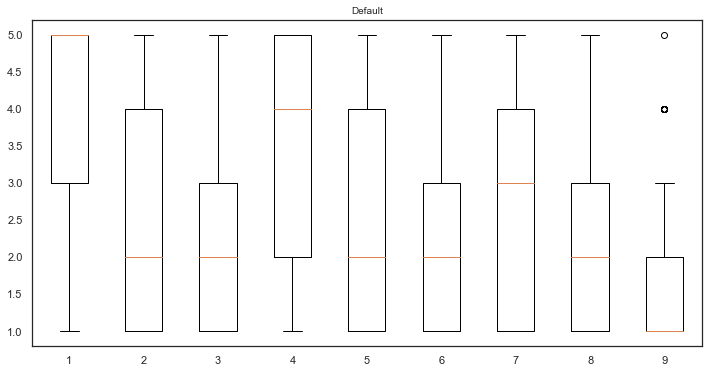

In [941]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(12, 6))
axs.boxplot(data)
axs.set_title('Default', fontsize=10)

Text(0.5, 1.0, 'Default')

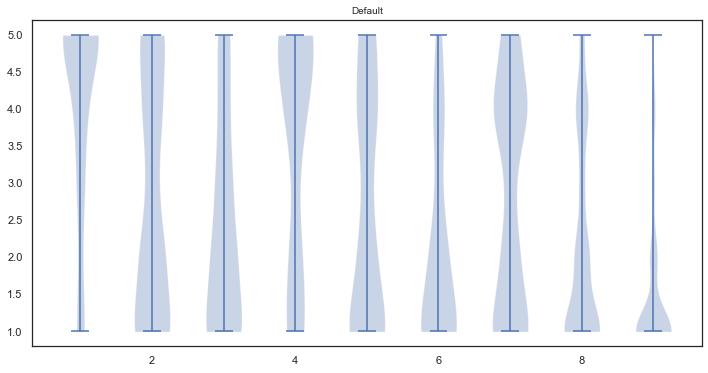

In [942]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(12, 6))
axs.violinplot(data)
axs.set_title('Default', fontsize=10)

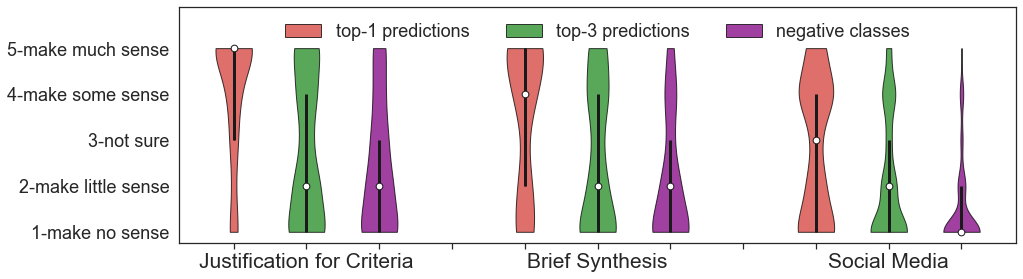

In [943]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels, ylabels = None):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontsize=21)
    if ylabels:
        ax.set_yticks(np.arange(1, len(ylabels) + 1))
        ax.set_yticklabels(ylabels,fontsize=21)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_ylim(0.75, 5.9)
    ax.tick_params(axis='y', labelsize=18)
    #ax.set_xlabel('Sample name',fontsize=18)
   
    
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
pos = [1,2,3,5,6,7,9,10,11]

#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

#ax2.set_title('Customized violin plot')
parts = ax2.violinplot(
        data, pos, showmeans=False, showmedians=False,
        showextrema=False)

colors = ['#D43F3A', 'forestgreen', 'purple']

for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_facecolor(colors[i%3])
    pc.set_edgecolor('black')
    pc.set_alpha(0.75)

quartile1, medians, quartile3 = ([],[],[])
for i in range(len(data)):
    quartile1.append(np.percentile(data[i], 25))
    medians.append(np.percentile(data[i], 50))
    quartile3.append(np.percentile(data[i], 75))
    
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(pos, medians, marker='o', color='white', s=45, zorder=3,edgecolor='k')
ax2.vlines(pos, quartile1, quartile3, color='k', linestyle='-', lw=3)
ax2.vlines(pos, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['', 'Justification for Criteria', '','', '', 'Brief Synthesis', '','','', 'Social Media', '']
ylabels = ['1-make no sense', '2-make little sense', '3-not sure', '4-make some sense', '5-make much sense']
for ax in [ax1, ax2]:
    set_axis_style(ax, labels, ylabels)

ax.legend([parts["bodies"][0], parts["bodies"][1], parts["bodies"][2]],
          ['top-1 predictions', 'top-3 predictions','negative classes'], loc='upper center', 
          ncol=3, fontsize=18, frameon=False)    

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

In [945]:
[len(d) for d in data]

[120, 240, 120, 96, 192, 96, 232, 464, 232]

In [946]:
[np.percentile(d, 50) for d in data]

[5.0, 2.0, 2.0, 4.0, 2.0, 2.0, 3.0, 2.0, 1.0]

### Non-parametric Tests for the Distributions

#### Kruskal-Wallis H Tests

In [947]:
stats.kruskal(data[0],data[1],data[2])

KruskalResult(statistic=68.41191765424935, pvalue=1.3948928018741948e-15)

In [948]:
stats.kruskal(data[3],data[4],data[5])

KruskalResult(statistic=38.22469964043411, pvalue=5.007395986149174e-09)

In [949]:
stats.kruskal(data[6],data[7],data[8])

KruskalResult(statistic=102.32145332519394, pvalue=6.041972166392382e-23)

In [951]:
stats.kruskal(np.concatenate([data[6],data[7],data[8]]),
              np.concatenate([data[3],data[4],data[5]]),np.concatenate([data[0],data[1],data[2]]))

KruskalResult(statistic=110.21220497686961, pvalue=1.1687557757448063e-24)

In [952]:
stats.kruskal(np.concatenate([data[0],data[3],data[6]]),
              np.concatenate([data[1],data[4],data[7]]),np.concatenate([data[2],data[5],data[8]]))

KruskalResult(statistic=184.33267213184166, pvalue=9.390069989704505e-41)

### Mann-Whitney U Tests

In [974]:
for i in range(9):
    for j in range(9):
        if i<j and ((j-i==2 and i not in [1,2,4,5]) or (j-i==1 and i not in [2,5])):
            print(i,j)
            print(stats.mannwhitneyu(data[i],data[j]))

0 1
MannwhitneyuResult(statistic=8157.0, pvalue=2.2413514188783913e-12)
0 2
MannwhitneyuResult(statistic=3161.0, pvalue=4.448213041617074e-15)
1 2
MannwhitneyuResult(statistic=12638.0, pvalue=0.02553981634675701)
3 4
MannwhitneyuResult(statistic=6256.0, pvalue=2.303516340132966e-06)
3 5
MannwhitneyuResult(statistic=2401.5, pvalue=1.5338799854926273e-09)
4 5
MannwhitneyuResult(statistic=7603.5, pvalue=0.005720740227056704)
6 7
MannwhitneyuResult(statistic=40629.0, pvalue=1.3115907989947074e-08)
6 8
MannwhitneyuResult(statistic=13784.5, pvalue=1.988954931232016e-23)
7 8
MannwhitneyuResult(statistic=39284.5, pvalue=4.574464592358076e-11)
